<center><h1>  1. zadaća </h1></center>
<center><h1>Algoritmi za određivanje konveksne ljuske skupa točaka </h1></center>
<center><h6> Sara Pužar </h6></center>

<i><center>Podatci nad kojima su se vršila testiranja i primjeri iskonstruirani su u sklopu ove zadaće.
    U narednim blokovima odrađeni su svi uvozi modula i paketa potrebnih i korištenih u radu. </center></i>

In [60]:
# Moduli i paketi

import numpy as np
import pandas as pd
import scipy as sp
import random as rand
import functools as func
import time
import matplotlib.animation
import matplotlib.pyplot as plt
import pylab as pylab
from IPython.display import display, Image
import matplotlib.image as mpimg
import matplotlib.patches as patch

<h2> Uvod </h2>

Konveksna ljuska nekog skupa $S$ je najmanji konveksni skup $D$ koji sadrži dani skup. Određivanje takvog skupa i algoritmi koji se pritom koriste imaju raznoliku primjenu o kojoj će biti riječi nešto kasnije. Za početak ćemo matematički definirati osnovne pojmove vezane uz temu ovoga rada. 

$ \textbf{Definicija 1.} $
 Kažemo da je skup $ D \subseteq \mathbb{R}^{n} $ konveksan ako za bilo koje dvije točke $ x_{1}, x_{2} \in \mathbb{R}^{n} $ sadrži i segment određen tim točkama.

$$ x_{1}, x_{2} \in D \Rightarrow \lambda x_{1} + ( 1 - \lambda ) x_{2}  \in D , \:\: \forall \lambda \in [ 0, 1 ]$$

U nastavku slijedi primjer konveksnog i nekonveksnog peterokuta.

<h6> Primjer 1. </h6>
Konveksni i nekonveksni peterokut

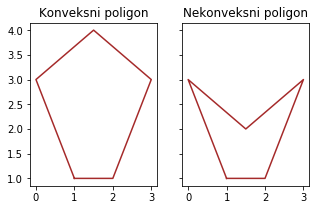

In [61]:
%matplotlib inline

Convex = [[1,1], [2,1], [3,3], [1.5,4], [0, 3]]
Convex.append(Convex[0]) 
x, y = zip(*Convex) 

notConvex = [[1,1], [2,1], [3,3], [1.5,2], [0, 3]]
notConvex.append(notConvex[0]) 
x_, y_ = zip(*notConvex)

plot_difference, (left, right ) = plt.subplots(1, 2, figsize=(5,3), sharey=True)
left.set_title('Konveksni poligon')
left.plot( x, y, color='brown')
right.set_title('Nekonveksni poligon')
right.plot( x_, y_, color='brown')


$ \textbf{Definicija 2.} $ Neka je skup $ S  \subseteq \mathbb{R}^{n}$. Konveksna ljuska skupa $ S $ je skup svih konveksnih kombinacija točaka iz $ S $. 
$$ conv(S) = \{ \lambda_{1}x_{1} + \lambda_{2}x_{2} + ... + \lambda_{m}x_{m} : x_{1}, x_{2}, ... , x_{m} \in S, \: \lambda_{1}, \lambda_{2}, ... , \lambda_{m} \in [0, 1],  \sum\limits_{1}^{m} \lambda_{i} = 1 \} $$
Drugim riječima, konveksna ljuska je najmanji konveksni skup koji sadrži skup S.

<h6> Primjer 2. </h6>
Skup točaka i njegova konveksna ljuska.

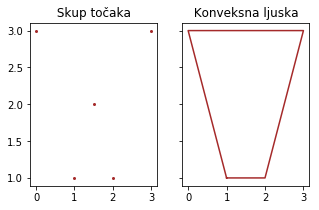

In [62]:
Set = [[1,1], [2,1], [3,3], [1.5,2], [0, 3]]
ConvexHull = [[1,1], [2,1], [3,3], [0, 3]]
ConvexHull.append(ConvexHull[0])
x1, y1 = zip(*ConvexHull)
x2, y2 = zip(*Set)  

Hull_of_Set, (left_, right_ ) = plt.subplots(1, 2, figsize=(5, 3), sharey=True)
left_.set_title(" Skup točaka ")
left_.scatter( x2, y2, color='brown', s=4) 
right_.set_title(" Konveksna ljuska ")
right_.plot( x1, y1, color='brown')


<h3> O algoritmima </h3>  

U ovom radu baviti ćemo se određivanjem konveksne ljuske nekog skupa točaka iz ravnine. 
Slijedi prikaz i implementacija pomoćnih funkcija koje ćemo kasnije koristiti u algoritmima za određivanje koveksne ljuske.

<h6> Lijeva orijentacija </h6>
Funkcija <code> left_turn </code> prima tri točke te za te tri točke računa vektorski produkt. Radi čitljivosti i boljeg razumijevanja kasnijeg koda nazvana je <i> left_turn </i>.  


In [63]:
def left_turn( point_A, point_B, point_C):
    vector_AB = [point_B[0] - point_A[0], point_B[1] - point_A[1]] 
    vector_AC = [point_C[0] - point_A[0], point_C[1] - point_A[1]]
    return np.cross( vector_AB, vector_AC )

<h6> Primjer 3. </h6>

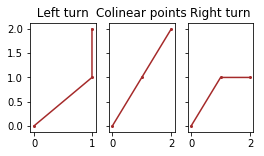

In [64]:
left     = [[0,0], [1,1], [1,2]]
right    = [[0,0], [1,1], [2,1]]
colinear = [[0,0], [1,1], [2,2]]
l1,l2 = zip(*left)
r1,r2 = zip(*right)
c1,c2 = zip(*colinear)

Orientation, (left, middle, right ) = plt.subplots(1, 3, figsize=(4, 2), sharey=True)
left.set_title(" Left turn ")
left.scatter( l1,l2, color='brown', s = 4) 
left.plot(l1,l2, color='brown')
middle.set_title("Colinear points")
middle.scatter( c1,c2, color='brown', s = 4)
middle.plot(c1,c2, color='brown')
right.set_title("Right turn")
right.scatter( r1,r2, color='brown', s = 4)
right.plot(r1,r2,color='brown')

<h6> Udaljenost </h6>
Funkcija <code> distance </code> prima dvije točke te vraća kvadrat njihove udaljenosti. Kako će nam u daljnjem radu biti potreban samo omjer udaljenosti točaka, nema potrebe za računanjem egzaktne vrijednosti već  zbog monotonosti korijena gledamo izraz ispod korijena.

In [65]:
def distance( point_A, point_B):
    return (  ( point_A[0] - point_B[0])**2 
            + ( point_A[1] - point_B[1])**2);

<h6> Početna točka </h6>
Funkcija <code> lowest_point </code> i <code> leftmost_point </code> primaju listu točaka te vraćaju najnižu, 
odnosno najlijeviju točku.

In [66]:
def lowest_point( array_points ):
    minY = array_points[0]
    for point in array_points:
        if (   ( point[1] < minY[1] ) 
            or ( point[1] == minY[1] and point[0] < minY[0] ) ):
            minY = point
    return minY

def leftmost_point( array_points ):
    minX = array_points[0]
    for point in array_points:
        if (   ( point[0] < minX[0] ) 
            or ( point[0] == minX[0] and point[1] < minX[1] ) ):
            minX = point
    return minX

<h6> Pomoćna funkcija za sortiranje </h6>
Funkcija <code> function_for_sort </code> pomoćna je funkcija koju predajemo funkciji Pythonovoj <code>sorted</code> funkciji kao argument. <code> Function_for_sort </code> unutar funkcije <code>sorted</code> poziva se s dva elementa koji se uspoređuju na način kao što je zapisano u funkciji te prema specifičnom kriteriju sortiraju predanu listu.

In [67]:
def function_for_sort( x, y ):  
    global P_0
    coef = left_turn(P_0, x, y)
    if coef > 0 :
        return -1
    elif coef == 0:
        if distance(P_0, x) < distance(P_0, y):
            return -1
    return 1

<h2> Graham algoritam </h2>

<i>Graham's scan </i> algoritam metoda je za pronalazak konveksne ljuske skupa točaka. Ime je dobio po Ronald Grahamu koji je algoritam objavio 1972. Vremenska složenost algoritma ovisi o sortiranju, stoga se uzima da algoritam ima složenost $\mathcal{O}(n\log{}n)$.

<center><h4> Određivanje konveksne ljuske za skup S koji se sastoji od  n točaka </h4></center> 

1. Odrediti početnu točku, $P_{0}$
2. Sortirati sve ostale točke po polarnom kutu s ozirom na točku $P_{0}$
3. Na stog staviti zadnju pa prvu točku sortirane liste
4. Ponavljati n-2 puta : 
Za sljedeću točku u sortiranoj listi provjeriti čine li    dvije vršne točke sa stoga s njom lijevi okret
<br> Da : stavljamo i novu točku na stog
<br> Ne : izbacujemo točku s vrha stoga


<h6> <code> Graham </code> </h6>
Funkcija prima listu točaka te na gore opisani način određuje te vraća listu točaka koje određuju konveksnu ljusku zadanog skupa.

In [68]:
def Graham( array_of_points ):
    new_array = list(array_of_points)
    global P_0 
    P_0 = leftmost_point( new_array )
    new_array.remove( P_0 )
    new_array = sorted( new_array, key=func.cmp_to_key(function_for_sort))
    Convex_hull = []
    Convex_hull.append(new_array[-1])
    Convex_hull.append( P_0 )
    index = 0
    size = len(new_array)
    while( index != size ):
        examination_point = new_array[index]
        try:
            Convex_hull[-2]
        except:
            index += 1
            continue
        if ( left_turn( Convex_hull[-2], Convex_hull[-1], examination_point ) > 0 ):
            Convex_hull.append( examination_point )
            index += 1
        else:
            Convex_hull.pop()
    return Convex_hull

<h6> Primjer 4. </h6>
Primjer malog skupa  i njegove konveksne ljuske određene Grahamovim algoritmom.

In [69]:
Example_set = [[1,1], [0,1], [3,3], [1.5,2], [0, 3], [1,2] ,[4,4] ]
Convex_set = Graham( Example_set )

print("Skup: ",Example_set)
print("Konveksna ljuska: ",Convex_set)

Skup:  [[1, 1], [0, 1], [3, 3], [1.5, 2], [0, 3], [1, 2], [4, 4]]
Konveksna ljuska:  [[0, 3], [0, 1], [1, 1], [4, 4], [0, 3]]


<h6> Primjer 5. </h6>
Grafički prikaz za n nasumično izabranih točaka i njihove konveksne ljuske izračunate Grahamovim algoritmom.

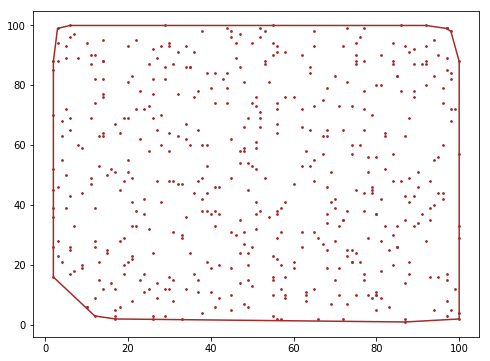

In [70]:
def random_skup( n ):
    array_ = []
    for x in range(n):
        point = [ rand.randint(1,100), rand.randint(1,100) ]
        array_.append(point)
    return array_

# Odaberite veličinu skupa 
veličina_skupa = 500
Set_of_points = random_skup( veličina_skupa )
ConvexHull_array = Graham( Set_of_points )
P_0 = leftmost_point( Set_of_points )

ConvexHull_array.append(ConvexHull_array[0])
x1, y1 = zip(*Set_of_points)
x2, y2 = zip(*ConvexHull_array) 
 
Hull = plt.figure(figsize=(8,6))
ax1 = Hull.add_subplot(111)
ax1.scatter( x1, y1, color='brown', s=3)
ax1.plot( x2, y2, color='brown')


#display( Image( filename='test_data/primjer6.png' ) )

<h6> <code> Graham_construct_animation </code> </h6>
Sljedeća funkcija jest modificirana verzija <code> Graham </code> funkcije pomoću koje se omogućava animirian prikaz koraka koje algoritam provodi prilikom određivanja konveksne ljuske.

In [71]:
def Graham_construct_animation( array_of_points ):
    animate_Convex_hull =[]
    new_array = list(array_of_points)
    global P_0 
    P_0 = leftmost_point( new_array )
    new_array.remove( P_0 )
    new_array = sorted( new_array, key=func.cmp_to_key(function_for_sort))
    Convex_hull = []
    Convex_hull.append(new_array[-1])
    Convex_hull.append( P_0 )
    index = 0
    temp = 0
    size = len(new_array)
    while( index != size ):
        temp = temp + 1
        examination_point = new_array[index]
        Convex_hull.append( examination_point)
        animate_Convex_hull.append(Convex_hull[1:-1])
        Convex_hull.remove( examination_point)
        try:
            Convex_hull[-2]
        except:
            index += 1
            continue
        if ( left_turn( Convex_hull[-2], Convex_hull[-1], examination_point ) > 0 ):
            Convex_hull.append( examination_point )
            index += 1
        else:
            Convex_hull.pop()
            
    Convex_hull.append(Convex_hull[0])
    animate_Convex_hull.append(Convex_hull)
    return animate_Convex_hull


<h6> Primjer 6. </h6>
Animirani prikaz rada Grahamovog algoritma na skupu od 50 točaka.

In [72]:
Example_array = []
for x in range(50):
    point = [ rand.randint(1,100), rand.randint(1,100) ]
    Example_array.append(point)

Scatter_pointsX, Scatter_pointsY =  zip(*Example_array)
ConvexHull_animation =  Graham_construct_animation( Example_array ) 

fig, ax = plt.subplots()
ax.axis([0,100, 0, 100])
ax.scatter(Scatter_pointsX, Scatter_pointsY, s = 2, color = 'black' )
l, = ax.plot([],[])

def animate(i, Convex_data, ax):
    top = len(Convex_data)
    if i >= 1 and  i<= top:
        processing_data = Convex_data[i] 
        x_axes, y_axes = zip(*processing_data)
        l.set_data(x_axes[:i], y_axes[:i])
    
%matplotlib inline

ani = matplotlib.animation.FuncAnimation(fig, animate, len(ConvexHull_animation),fargs=( ConvexHull_animation, ax))

from IPython.display import HTML
HTML(ani.to_jshtml())

<h2> Jarvis march </h2>

<i> Jarvis march </i> algoritam još je poznat kao i algoritam omatanja poklona zbog načina na koji omota sam skup točaka. Vremenska složenost ovog algoritma varira od gotovo $\mathcal{O}(hn)$, gdje $h$ predstavlja broj točaka koje određuju konveksnu ljusku.

<center><h4> Određivanje konveksne ljuske za skup S koji se sastoji od  n točaka </h4></center> 

1. Odrediti početnu točku, $P_{0}$. $P_{min}$ = $P_{0}$
2. Ponavljati dok je $P_{min}$ različito $P_{next}$ :
 Odredimo točku $P_{next}$ koja zatvara najmanji polarni kut s  $P_{min}$. 
 Stavljamo na stog nađenu točku $P_{next}$. 
 $P_{0}$ = $P_{next}$ 


In [73]:
def Jarvis( array_of_points ):
    new_array = list(array_of_points) 
    P_0 = lowest_point( new_array )
    P_min = P_0
    Convex_hull = []
    P_next = P_0
    start = 1
    while( start or P_next != P_0):
        start = 0
        for examination_point in new_array:
            coef = left_turn( P_min, P_next, examination_point) 
            if coef < 0:
                P_next = examination_point
            elif coef == 0:
                if distance( P_min, P_next) < distance(P_min, examination_point) and examination_point != P_next:
                    P_next = examination_point
        P_min = P_next
        Convex_hull.append(P_next)
    return Convex_hull

<h6> Primjer 7. </h6>
Primjer malog skupa  i njegove konveksne ljuske određene Grahamovim algoritmom.

In [74]:
Example_set = [[1,1], [0,1], [3,3], [1.5,2], [0, 3], [1,2] ,[4,4] ]
Convex_set = Jarvis( Example_set )

print("Skup: ",Example_set)
print("Konveksna ljuska: ",Convex_set)

Skup:  [[1, 1], [0, 1], [3, 3], [1.5, 2], [0, 3], [1, 2], [4, 4]]
Konveksna ljuska:  [[1, 1], [4, 4], [0, 3], [0, 1]]


<h6> Primjer 8. </h6>
Grafički prikaz n nasumično izabranih točaka i njihove konveksne ljuske izračunate Jarvis algoritmom.

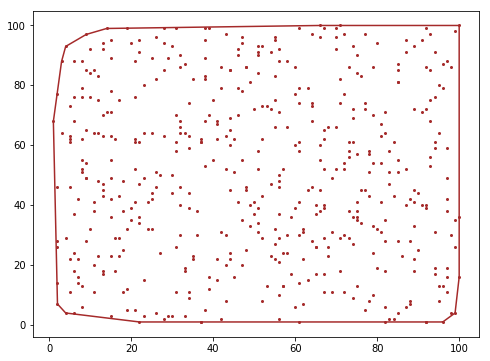

In [75]:
%matplotlib inline

veličina_skupa = 500
Set_of_points = random_skup( veličina_skupa )

ConvexHull_array = Jarvis( Set_of_points )

ConvexHull_array.append(ConvexHull_array[0])
x1, y1 = zip(*Set_of_points)
x2, y2 = zip(*ConvexHull_array) 

Hull = plt.figure(figsize=(8,6))
ax1 = Hull.add_subplot(111)
ax1.scatter( x1, y1, color='brown', s=4)
ax1.plot( x2, y2, color='brown')

#display( Image( filename='test_data/primjer6.png' ) )

In [76]:
def Jarvis_construct_animation( array_of_points ):
    animate_Convex_hull =[]
    new_array = list(array_of_points) 
    P_0 = lowest_point( new_array )
    new_array = sorted( new_array, key=func.cmp_to_key(function_for_sort))
    P_min = P_0
    Convex_hull = []
    P_next = P_0
    start = 1
    while( start or P_next != P_0):
        start = 0
        for examination_point in new_array:
            coef = left_turn( P_min, P_next, examination_point) 
            if coef < 0:
                Convex_hull.append(examination_point)
                animate_Convex_hull.append(Convex_hull)
                Convex_hull.remove(examination_point)
                P_next = examination_point
            elif coef == 0:
                if distance( P_min, P_next) < distance(P_min, examination_point) and examination_point != P_next:
                    Convex_hull.append(examination_point)
                    animate_Convex_hull.append(Convex_hull)
                    Convex_hull.remove(examination_point)
                    P_next = examination_point
        P_min = P_next
        Convex_hull.append(P_next)
    Convex_hull.append(Convex_hull[0])
    animate_Convex_hull.append(Convex_hull)
    return animate_Convex_hull

<h6> Primjer 9. </h6>
Animirani prikaz rada Jarvis march algoritma na skupu od 50 točaka.

In [77]:
Example_array = []
for x in range(50):
    point = [ rand.randint(1,100), rand.randint(1,100) ]
    Example_array.append(point)

Scatter_pointsX, Scatter_pointsY =  zip(*Example_array)
ConvexHull_animation =  Jarvis_construct_animation( Example_array ) 

fig, ax = plt.subplots()
ax.axis([0,100, 0, 100])
ax.scatter(Scatter_pointsX, Scatter_pointsY, s = 2, color = 'black' )
l, = ax.plot([],[])

def animate(i, Convex_data, ax):
    top = len(Convex_data)
    if len(Convex_data[i]) > 1:
        processing_data = Convex_data[i] 
        x_axes, y_axes = zip(*processing_data)
        l.set_data(x_axes[:i], y_axes[:i])
    
%matplotlib inline

ani = matplotlib.animation.FuncAnimation(fig, animate, len(ConvexHull_animation),fargs=( ConvexHull_animation, ax))

from IPython.display import HTML
HTML(ani.to_jshtml())

<h2> Analiza algoritma Graham vs Jarvis </h2>


<h6> Analiza trajanja izvršavanja </h6>

<h6> Primjer 10. </h6>
Prosečno vrijeme potrebno za izvršavanje algoritama na skupovima od 1000 do 100_000 točaka u 100 puta. Kao što smo već spomenuli, složenost Grahamovog algoritma je $\mathcal{O}(n\log{n})$ dok Jarvisova može za određene skupove biti i $\mathcal{O}(n^{2})$

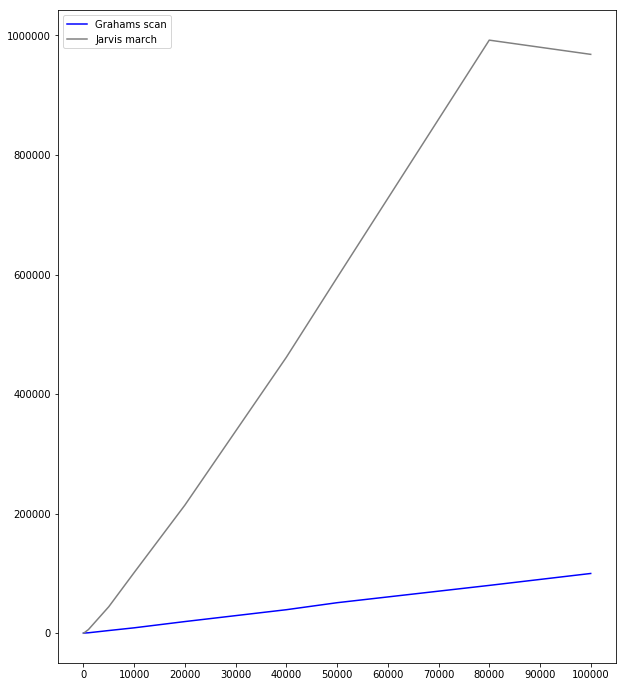

In [78]:
display( Image( filename='test_data/time_com.png' ) )

<h6> Odnos broja točaka skupa i broja točaka koje određuju pripradnu konveksnu ljusku </h6>

In [79]:
def random_skup( broj_točaka ):
    array_ = []
    for x in range(broj_točaka):
        point = [ rand.randint(0,100), rand.randint(0,100),]
        array_.append(point)
    return array_

def Testiranje(broj_testova, broj_točaka):
    Num_Convex = []
    Convex = []    
    for i in range( len(broj_točaka) ):
        for j in range (broj_testova):
            Points = random_skup( broj_točaka[i] )
            Convex = Graham(Points)
            Num_Convex.append([broj_točaka[i], len(Convex)])
    return Num_Convex

<h6> Primjer 11. </h6>
Grafički prikaz testiranja sprovedenog na 1000 generiranih skupova za svaki od broja_točaka.

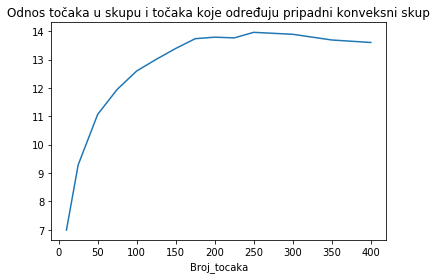

In [80]:
display( Image( filename='test_data/Za1000.png' ) )

<h6> Primjer 12. </h6>
Unesite svoje podatke za testiranje.<br>
Varijabla <code> broj_pokusa </code> određuje koliko će se nasumičmnih skupova generirati za određenu veličinu skupa.<br>
U listi <code> broj_točaka </code> određujete veličinu skupova za testiranje.

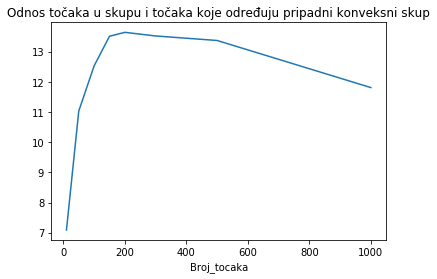

In [97]:

broj_pokusa = 400
broj_točaka = [10, 50, 100, 150, 200]

Num_Convex_4 = Testiranje(broj_pokusa, broj_točaka)

data_4 =  pd.DataFrame.from_records(Num_Convex_4, columns=[ 'Broj_tocaka', 'Broj_tocaka_Conv'])
Analiza_4 = data_4.groupby('Broj_tocaka')['Broj_tocaka_Conv'].mean()
Analiza_4.plot( x = 'Broj točaka u skupu', y = 'Broj točaka koje određuju konveksnu ljusku',title = 'Odnos točaka u skupu i točaka koje određuju pripadni konveksni skup')


<h6> Primjer 13. </h6>
Sljedeći graf prikazuje iste podatke, međutim prikazane u logaritamskoj skali.

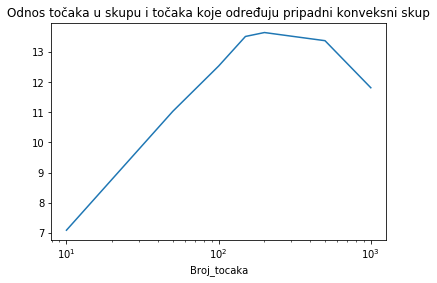

In [98]:
Analiza_4.plot( x = 'Broj točaka u skupu', y = 'Broj točaka koje određuju konveksnu ljusku', logx=True, title = 'Odnos točaka u skupu i točaka koje određuju pripadni konveksni skup')

<h2> Primjena </h2>

Algoritmi za određivanje konveksne ljuske točaka primjenjuju se u različitim područjima znanosti.
Neke od najpopularnijih primjena su :
- <h6> Evakuacija u slučaju nuklearnih katastrofa </h6>
U slučaju nuklearnih katrastrofa kao što je curenje iz nuklearnih elektrana potrebno je što prije i sa što većom sigurnošću odrediti područje evakuacije. U takvim slučajevima česta je primjena navedenih algoritama.
- <h6> Praćenje širenja epidemije </h6>
Prilikom izbijanja epidemije, poželjno je modulirati daljnje širenje epidemije kako bi se moglo upozoriti stanovništvo te smanjiti ili spriječiti daljne zaraze. Algoritmi za konveksne ljuske se koriste pri predviđanju prostornog širenja zaraze.
- <h6>  Linearno programiranje </h6>
Konveksni algoritmi koriste se pri implementaciji Simplex algoritma koji pronalaze optimalna rješenja nekog linearnog problema.
- <h6> Umjetna inteligencija </h6>
Prilikom kreiranja inteligentih agenata često postoji zahtjev za samostalnim kretanjem. Kako bi implementirali mogućnost samostalnog određivanja optimalnih puteva koriste se navedeni algoritmi.

<h2> 3D konveksne ljuske ( konveksna zatvorenja ) </h2>
 

Za prikaz konveksne ljuske u više dimenzija koristiti ćemo algoritam implementiran unutar <i> Scipy </m> modula. <code> scipy.spatial.ConvexHull </code> 

<h6> Primjer 13. </h6>
Primjer skupa i njegove konveksne ljuske u prostoru s 3 dimenzije. 

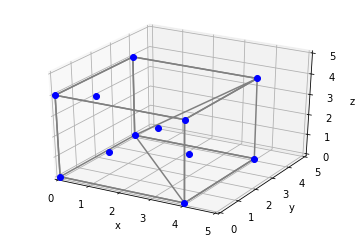

In [91]:
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial import ConvexHull  



Figura = plt.figure()
ax = Figura.add_subplot(111, projection='3d')

points= np.array([[0,0,0], [4,0,0], [2,2,2],
                [4,4,0], [3,2,1], [0,4,0],
                [0,0,4], [4,0,4], [4,4,4],
                [0,4,4], [1,1,1], [0,2,3]])

hull=ConvexHull(points)
edges = np.transpose(points)

for i in hull.simplices:
    plt.plot(points[i,0], points[i,1], points[i,2], 'grey')

ax.plot(edges[0],edges[1],edges[2],'bo') 

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

ax.set_xlim3d(0,5)
ax.set_ylim3d(0,5)
ax.set_zlim3d(0,5)

plt.show()